In [23]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [24]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [25]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
df_train = pd.read_csv("/content/drive/MyDrive/mnist_train.csv")
df_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_test_val = pd.read_csv("/content/drive/MyDrive/mnist_test.csv")
df_test_val.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df = pd.concat([df_train, df_test_val], axis=0)
df_train, temp = train_test_split(df, train_size=0.60, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.50, random_state=42)

In [42]:
X_train = df_train.drop('label', axis=1).values
X_train = X_train / 255.0
y_train = df_train['label'].values

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [43]:
X_val = df_val.drop('label', axis=1).values
y_val = df_val['label'].values

X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_val = torch.tensor(y_val, dtype=torch.long)

dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [44]:
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test = torch.tensor(y_test, dtype=torch.long)

dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [45]:
class CNN_dropout(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.dropout = nn.Dropout(rate)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1) # flattening the matrix
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [46]:
def trainCNN(Model):
    model = Model.to(device)
    lossType = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_losses = []
    val_losses = []

    for epoch in range(20):
      model.train()
      running_loss = 0
      #tupple of the inputs and their label
      for i, data in enumerate(train_loader,0):
        optimizer.zero_grad() #resetting gradients
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) #using gpu
        outputs = model(inputs) #forward propagation
        loss = lossType(outputs, labels)
        loss.backward() #backward propagation
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % 500 == 0 or (i + 1) % 999 == 0:
                print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.4f}")
                running_loss = 0.0

      avg_train_loss = running_loss / (i+1)
      train_losses.append(avg_train_loss)

      avg_val_loss = evaluateValLoss(model)
      val_losses.append(avg_val_loss)
    plot_losses(train_losses, val_losses)
    return model


In [47]:
def evaluateValLoss(model):
  total_loss=0
  samples=0
  model.eval()
  with torch.no_grad():
      for data in val_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device) #using gpu
          outputs = model(images)
          loss = nn.CrossEntropyLoss()(outputs,labels)
          total_loss += loss.item() * images.size(0)
          samples += images.size(0)

  final_loss = total_loss/samples
  return final_loss

In [48]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
def evaluateValCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            # returns max value & the indeces of the values
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    return accuracy

In [50]:
def evaluateTestCNN(model):
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) #using gpu
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100*correct)/total
    print(f"Accuracy: {accuracy}") #99.18 with momentum = 0.9, without 98.52 no droprate
    return accuracy

In [51]:
rates = [0, 0.1, 0.3, 0.5, 0.7] # 0 drop rate is no reg
def tuneDropOutRates(modelClass):
    accuracies = []
    for Rate in rates:
        modelType = modelClass(Rate)
        model = trainCNN(modelType)
        accuracy = evaluateValCNN(model)
        accuracies.append(accuracy)
    for i in range(len(accuracies)):
        print(f"For rate: {rates[i]} Accuracy = {accuracies[i]}\n")

#For rate: 0 Accuracy = 99.2
# For rate: 0.1 Accuracy = 98.9
# For rate: 0.3 Accuracy = 98.5
# For rate: 0.5 Accuracy = 97.68
# For rate: 0.7 Accuracy = 94.92

[Epoch 1, Batch 500] loss: 8.8140
[Epoch 2, Batch 500] loss: 1.9340
[Epoch 3, Batch 500] loss: 1.3880
[Epoch 4, Batch 500] loss: 1.0446
[Epoch 5, Batch 500] loss: 0.8312
[Epoch 6, Batch 500] loss: 0.6958
[Epoch 7, Batch 500] loss: 0.6031
[Epoch 8, Batch 500] loss: 0.5234
[Epoch 9, Batch 500] loss: 0.4723
[Epoch 10, Batch 500] loss: 0.4416
[Epoch 11, Batch 500] loss: 0.4238
[Epoch 12, Batch 500] loss: 0.3812
[Epoch 13, Batch 500] loss: 0.3536
[Epoch 14, Batch 500] loss: 0.3246
[Epoch 15, Batch 500] loss: 0.3204
[Epoch 16, Batch 500] loss: 0.2998
[Epoch 17, Batch 500] loss: 0.2857
[Epoch 18, Batch 500] loss: 0.2813
[Epoch 19, Batch 500] loss: 0.2604
[Epoch 20, Batch 500] loss: 0.2526


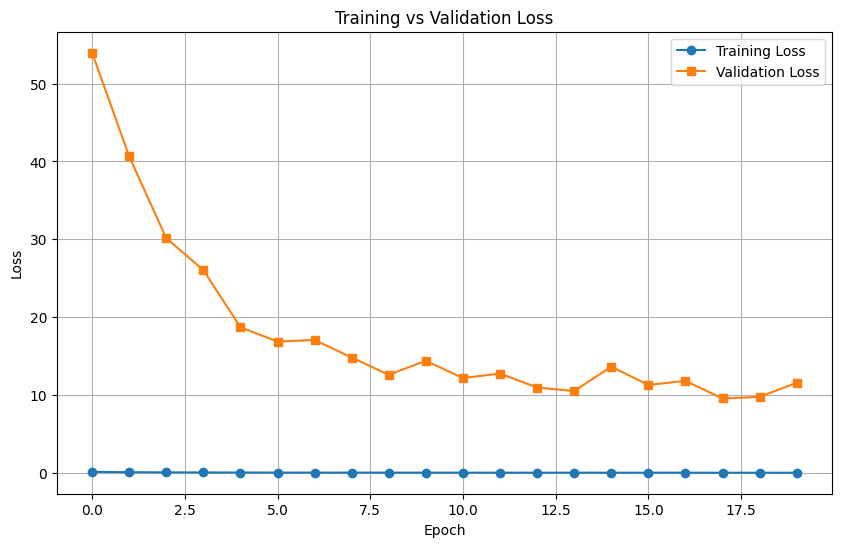

[Epoch 1, Batch 500] loss: 9.3792
[Epoch 2, Batch 500] loss: 2.1163
[Epoch 3, Batch 500] loss: 1.5385
[Epoch 4, Batch 500] loss: 1.1969
[Epoch 5, Batch 500] loss: 0.9435
[Epoch 6, Batch 500] loss: 0.7548
[Epoch 7, Batch 500] loss: 0.6502
[Epoch 8, Batch 500] loss: 0.5725
[Epoch 9, Batch 500] loss: 0.5264
[Epoch 10, Batch 500] loss: 0.4704
[Epoch 11, Batch 500] loss: 0.4394
[Epoch 12, Batch 500] loss: 0.4309
[Epoch 13, Batch 500] loss: 0.3926
[Epoch 14, Batch 500] loss: 0.3822
[Epoch 15, Batch 500] loss: 0.3520
[Epoch 16, Batch 500] loss: 0.3322
[Epoch 17, Batch 500] loss: 0.3154
[Epoch 18, Batch 500] loss: 0.2974
[Epoch 19, Batch 500] loss: 0.2964
[Epoch 20, Batch 500] loss: 0.2903


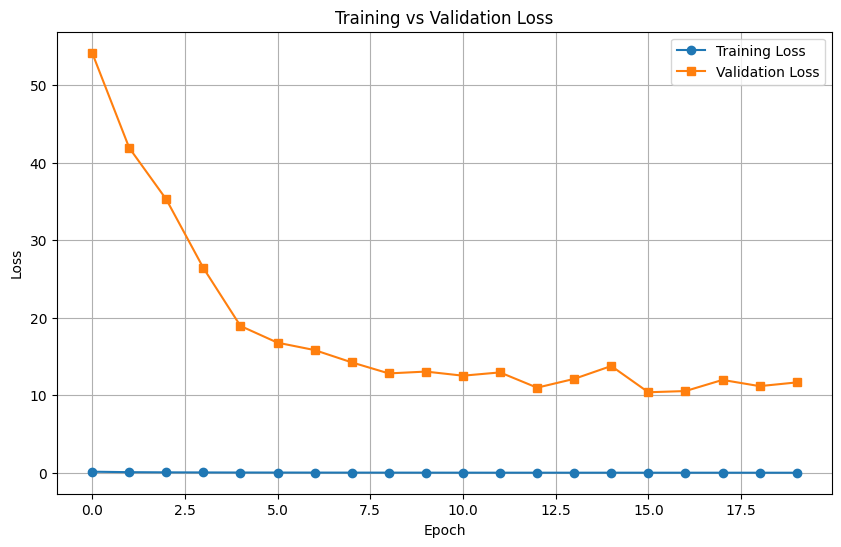

[Epoch 1, Batch 500] loss: 7.5502
[Epoch 2, Batch 500] loss: 2.0624
[Epoch 3, Batch 500] loss: 1.5056
[Epoch 4, Batch 500] loss: 1.1682
[Epoch 5, Batch 500] loss: 0.9406
[Epoch 6, Batch 500] loss: 0.7927
[Epoch 7, Batch 500] loss: 0.6898
[Epoch 8, Batch 500] loss: 0.6525
[Epoch 9, Batch 500] loss: 0.5829
[Epoch 10, Batch 500] loss: 0.5558
[Epoch 11, Batch 500] loss: 0.5001
[Epoch 12, Batch 500] loss: 0.4834
[Epoch 13, Batch 500] loss: 0.4478
[Epoch 14, Batch 500] loss: 0.4256
[Epoch 15, Batch 500] loss: 0.4008
[Epoch 16, Batch 500] loss: 0.3792
[Epoch 17, Batch 500] loss: 0.3703
[Epoch 18, Batch 500] loss: 0.3581
[Epoch 19, Batch 500] loss: 0.3301
[Epoch 20, Batch 500] loss: 0.3406


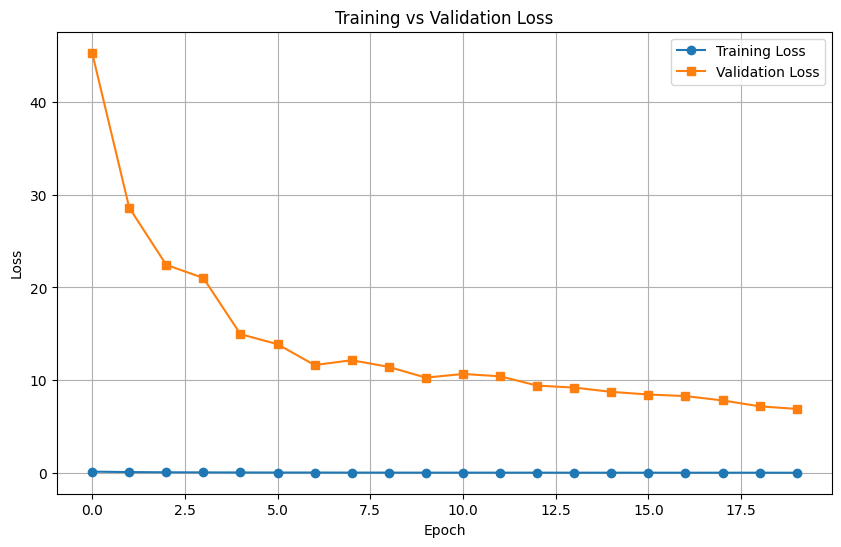

[Epoch 1, Batch 500] loss: 10.3096
[Epoch 2, Batch 500] loss: 2.6111
[Epoch 3, Batch 500] loss: 1.8945
[Epoch 4, Batch 500] loss: 1.4845
[Epoch 5, Batch 500] loss: 1.1850
[Epoch 6, Batch 500] loss: 1.0092
[Epoch 7, Batch 500] loss: 0.8934
[Epoch 8, Batch 500] loss: 0.8118
[Epoch 9, Batch 500] loss: 0.7110
[Epoch 10, Batch 500] loss: 0.6767
[Epoch 11, Batch 500] loss: 0.6458
[Epoch 12, Batch 500] loss: 0.6076
[Epoch 13, Batch 500] loss: 0.5654
[Epoch 14, Batch 500] loss: 0.5457
[Epoch 15, Batch 500] loss: 0.5240
[Epoch 16, Batch 500] loss: 0.4977
[Epoch 17, Batch 500] loss: 0.4774
[Epoch 18, Batch 500] loss: 0.4703
[Epoch 19, Batch 500] loss: 0.4439
[Epoch 20, Batch 500] loss: 0.4310


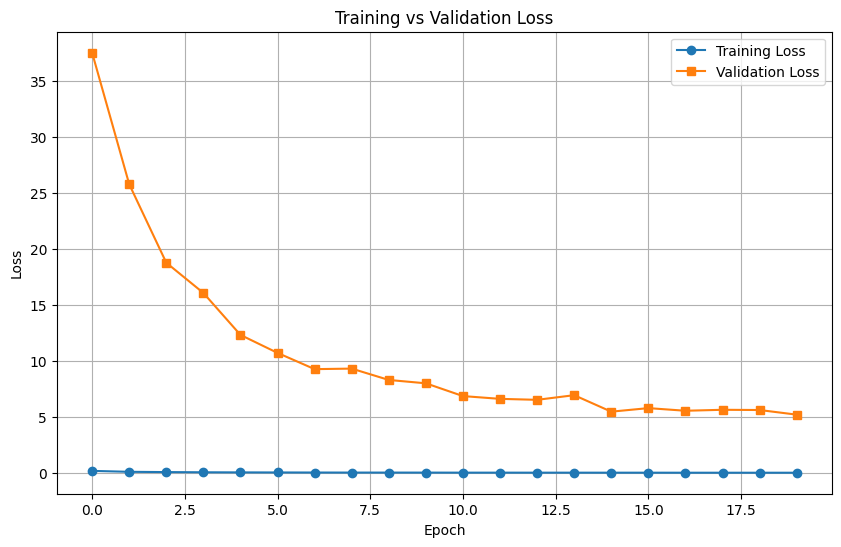

[Epoch 1, Batch 500] loss: 6.8896
[Epoch 2, Batch 500] loss: 2.8118
[Epoch 3, Batch 500] loss: 2.1584
[Epoch 4, Batch 500] loss: 1.7293
[Epoch 5, Batch 500] loss: 1.4529
[Epoch 6, Batch 500] loss: 1.3110
[Epoch 7, Batch 500] loss: 1.2119
[Epoch 8, Batch 500] loss: 1.1268
[Epoch 9, Batch 500] loss: 1.0289
[Epoch 10, Batch 500] loss: 0.9836
[Epoch 11, Batch 500] loss: 0.9340
[Epoch 12, Batch 500] loss: 0.9269
[Epoch 13, Batch 500] loss: 0.8755
[Epoch 14, Batch 500] loss: 0.8407
[Epoch 15, Batch 500] loss: 0.8387
[Epoch 16, Batch 500] loss: 0.8086
[Epoch 17, Batch 500] loss: 0.7909
[Epoch 18, Batch 500] loss: 0.7803
[Epoch 19, Batch 500] loss: 0.7737
[Epoch 20, Batch 500] loss: 0.7369


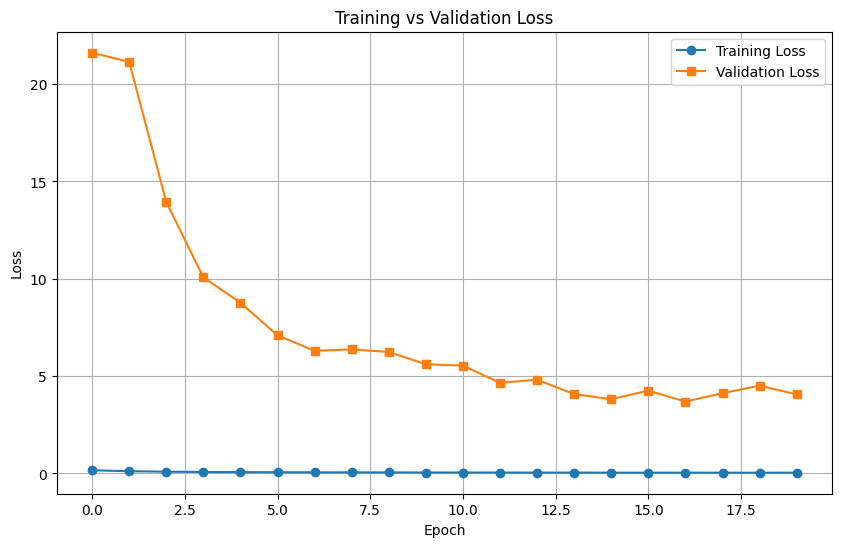

For rate: 0 Accuracy = 97.77857142857142

For rate: 0.1 Accuracy = 97.49285714285715

For rate: 0.3 Accuracy = 98.15

For rate: 0.5 Accuracy = 97.58571428571429

For rate: 0.7 Accuracy = 96.62857142857143



In [52]:
tuneDropOutRates(modelClass=CNN_dropout)

In [53]:
class CNN_batchNormalization(nn.Module):
    def __init__(self, rate):
        super().__init__()
        self.dropout = nn.Dropout(rate)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(32 * 5* 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

[Epoch 1, Batch 500] loss: 3.0010
[Epoch 2, Batch 500] loss: 0.6813
[Epoch 3, Batch 500] loss: 0.4892
[Epoch 4, Batch 500] loss: 0.3801
[Epoch 5, Batch 500] loss: 0.3250
[Epoch 6, Batch 500] loss: 0.2883
[Epoch 7, Batch 500] loss: 0.2626
[Epoch 8, Batch 500] loss: 0.2382
[Epoch 9, Batch 500] loss: 0.2242
[Epoch 10, Batch 500] loss: 0.1946
[Epoch 11, Batch 500] loss: 0.1916
[Epoch 12, Batch 500] loss: 0.1827
[Epoch 13, Batch 500] loss: 0.1685
[Epoch 14, Batch 500] loss: 0.1529
[Epoch 15, Batch 500] loss: 0.1498
[Epoch 16, Batch 500] loss: 0.1425
[Epoch 17, Batch 500] loss: 0.1331
[Epoch 18, Batch 500] loss: 0.1236
[Epoch 19, Batch 500] loss: 0.1209
[Epoch 20, Batch 500] loss: 0.1183


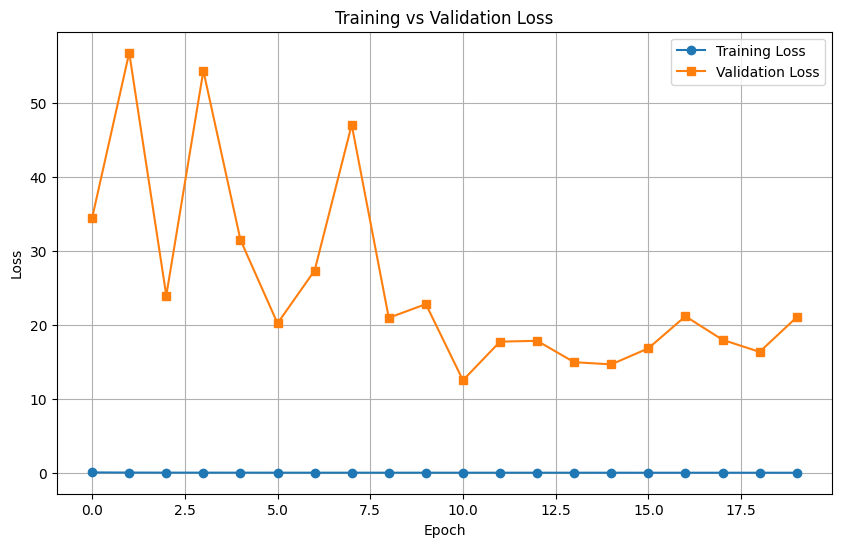

[Epoch 1, Batch 500] loss: 3.4447
[Epoch 2, Batch 500] loss: 0.8507
[Epoch 3, Batch 500] loss: 0.5951
[Epoch 4, Batch 500] loss: 0.4899
[Epoch 5, Batch 500] loss: 0.4217
[Epoch 6, Batch 500] loss: 0.3717
[Epoch 7, Batch 500] loss: 0.3422
[Epoch 8, Batch 500] loss: 0.3200
[Epoch 9, Batch 500] loss: 0.2954
[Epoch 10, Batch 500] loss: 0.2703
[Epoch 11, Batch 500] loss: 0.2571
[Epoch 12, Batch 500] loss: 0.2501
[Epoch 13, Batch 500] loss: 0.2298
[Epoch 14, Batch 500] loss: 0.2232
[Epoch 15, Batch 500] loss: 0.2191
[Epoch 16, Batch 500] loss: 0.2039
[Epoch 17, Batch 500] loss: 0.1909
[Epoch 18, Batch 500] loss: 0.1990
[Epoch 19, Batch 500] loss: 0.1830
[Epoch 20, Batch 500] loss: 0.1806


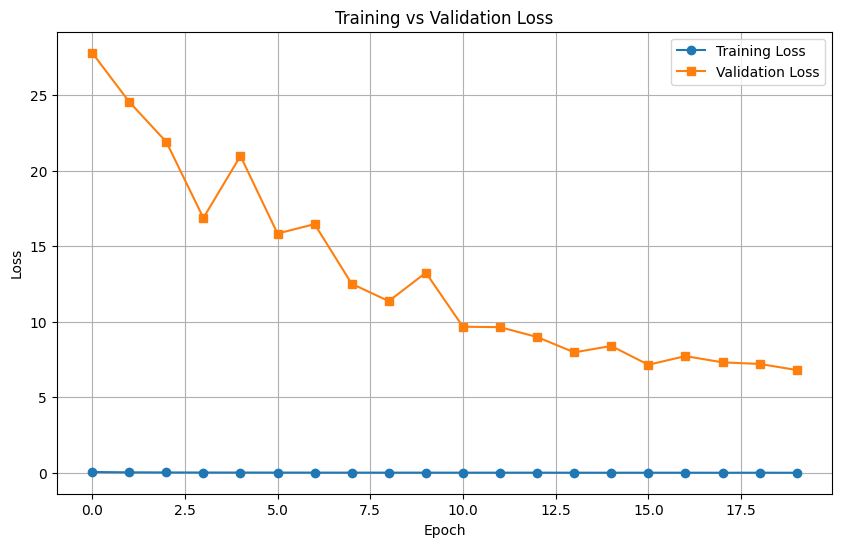

[Epoch 1, Batch 500] loss: 3.8952
[Epoch 2, Batch 500] loss: 1.1216
[Epoch 3, Batch 500] loss: 0.8379
[Epoch 4, Batch 500] loss: 0.6698
[Epoch 5, Batch 500] loss: 0.5663
[Epoch 6, Batch 500] loss: 0.5110
[Epoch 7, Batch 500] loss: 0.4646
[Epoch 8, Batch 500] loss: 0.4347
[Epoch 9, Batch 500] loss: 0.4116
[Epoch 10, Batch 500] loss: 0.3861
[Epoch 11, Batch 500] loss: 0.3514
[Epoch 12, Batch 500] loss: 0.3446
[Epoch 13, Batch 500] loss: 0.3287
[Epoch 14, Batch 500] loss: 0.3087
[Epoch 15, Batch 500] loss: 0.2922
[Epoch 16, Batch 500] loss: 0.2872
[Epoch 17, Batch 500] loss: 0.2811
[Epoch 18, Batch 500] loss: 0.2629
[Epoch 19, Batch 500] loss: 0.2616
[Epoch 20, Batch 500] loss: 0.2475


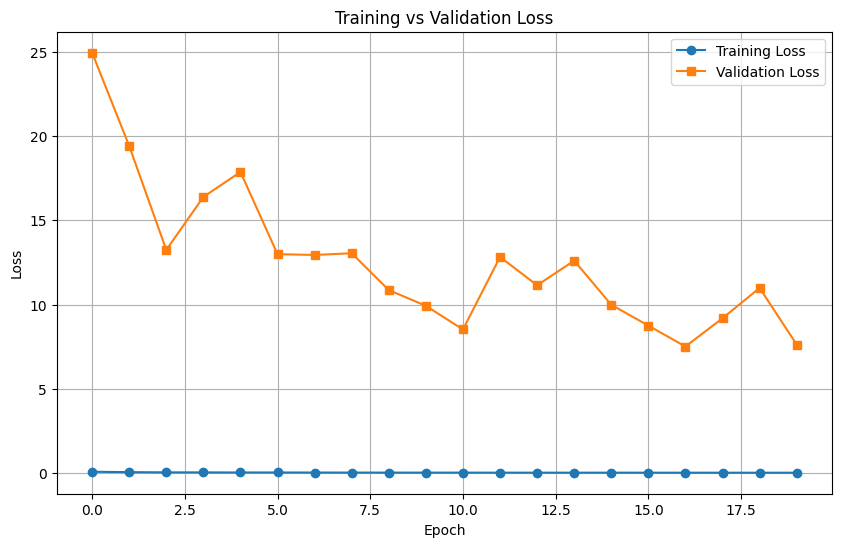

[Epoch 1, Batch 500] loss: 4.0262
[Epoch 2, Batch 500] loss: 1.4709
[Epoch 3, Batch 500] loss: 1.0881
[Epoch 4, Batch 500] loss: 0.8934
[Epoch 5, Batch 500] loss: 0.7833
[Epoch 6, Batch 500] loss: 0.7026
[Epoch 7, Batch 500] loss: 0.6458
[Epoch 8, Batch 500] loss: 0.5922
[Epoch 9, Batch 500] loss: 0.5568
[Epoch 10, Batch 500] loss: 0.5335
[Epoch 11, Batch 500] loss: 0.5147
[Epoch 12, Batch 500] loss: 0.4893
[Epoch 13, Batch 500] loss: 0.4595
[Epoch 14, Batch 500] loss: 0.4545
[Epoch 15, Batch 500] loss: 0.4383
[Epoch 16, Batch 500] loss: 0.4158
[Epoch 17, Batch 500] loss: 0.4185
[Epoch 18, Batch 500] loss: 0.4032
[Epoch 19, Batch 500] loss: 0.4006
[Epoch 20, Batch 500] loss: 0.3954


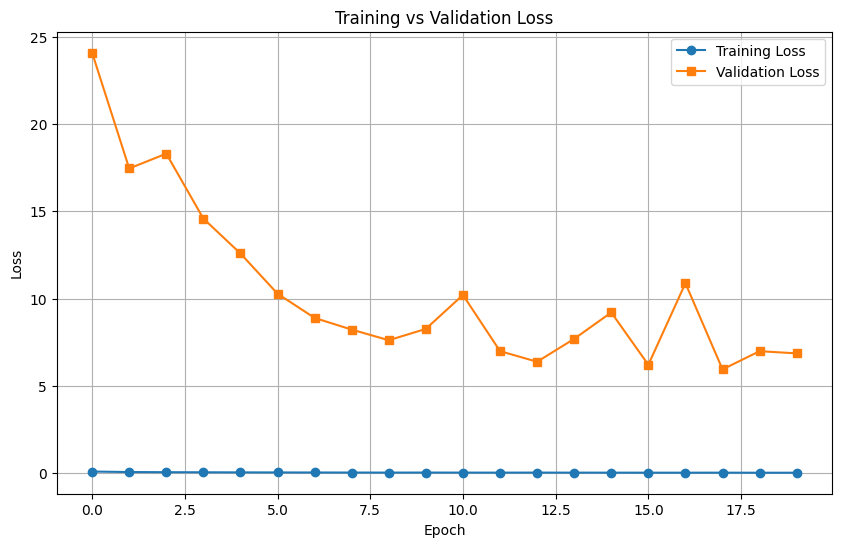

[Epoch 1, Batch 500] loss: 4.4883
[Epoch 2, Batch 500] loss: 2.0695
[Epoch 3, Batch 500] loss: 1.6341
[Epoch 4, Batch 500] loss: 1.4082
[Epoch 5, Batch 500] loss: 1.2712
[Epoch 6, Batch 500] loss: 1.1882
[Epoch 7, Batch 500] loss: 1.0808
[Epoch 8, Batch 500] loss: 1.0308
[Epoch 9, Batch 500] loss: 0.9875
[Epoch 10, Batch 500] loss: 0.9523
[Epoch 11, Batch 500] loss: 0.9025
[Epoch 12, Batch 500] loss: 0.8783
[Epoch 13, Batch 500] loss: 0.8483
[Epoch 14, Batch 500] loss: 0.8322
[Epoch 15, Batch 500] loss: 0.8072
[Epoch 16, Batch 500] loss: 0.8171
[Epoch 17, Batch 500] loss: 0.7711
[Epoch 18, Batch 500] loss: 0.7834
[Epoch 19, Batch 500] loss: 0.7318
[Epoch 20, Batch 500] loss: 0.7547


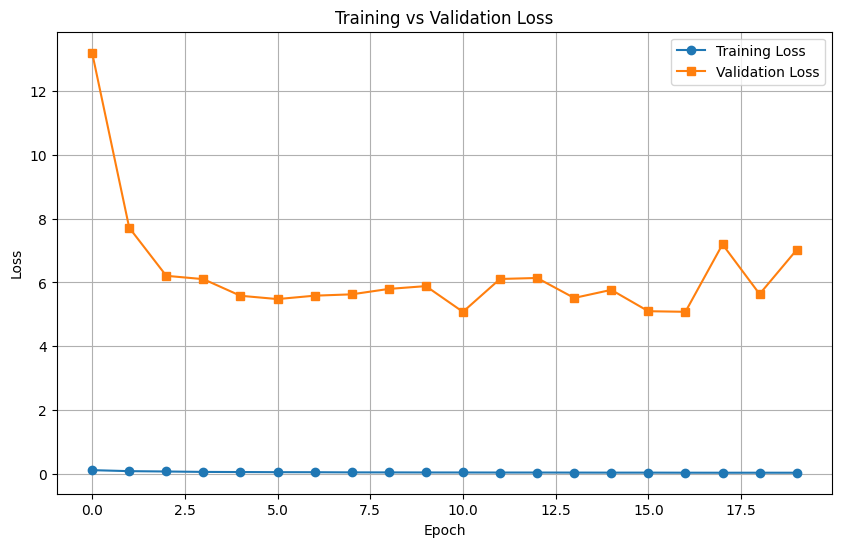

For rate: 0 Accuracy = 95.57142857142857

For rate: 0.1 Accuracy = 98.19285714285714

For rate: 0.3 Accuracy = 97.44285714285714

For rate: 0.5 Accuracy = 96.15714285714286

For rate: 0.7 Accuracy = 92.29285714285714



In [54]:
tuneDropOutRates(modelClass=CNN_batchNormalization)
# For rate: 0 Accuracy = 99.12
# For rate: 0.1 Accuracy = 98.94
# For rate: 0.3 Accuracy = 98.74
# For rate: 0.5 Accuracy = 97.62
# For rate: 0.7 Accuracy = 95.84

[Epoch 1, Batch 500] loss: 8.3239
[Epoch 2, Batch 500] loss: 2.2084
[Epoch 3, Batch 500] loss: 1.6205
[Epoch 4, Batch 500] loss: 1.2470
[Epoch 5, Batch 500] loss: 1.0379
[Epoch 6, Batch 500] loss: 0.8721
[Epoch 7, Batch 500] loss: 0.7381
[Epoch 8, Batch 500] loss: 0.6853
[Epoch 9, Batch 500] loss: 0.6147
[Epoch 10, Batch 500] loss: 0.5702
[Epoch 11, Batch 500] loss: 0.5267
[Epoch 12, Batch 500] loss: 0.5081
[Epoch 13, Batch 500] loss: 0.4803
[Epoch 14, Batch 500] loss: 0.4508
[Epoch 15, Batch 500] loss: 0.4313
[Epoch 16, Batch 500] loss: 0.4112
[Epoch 17, Batch 500] loss: 0.3856
[Epoch 18, Batch 500] loss: 0.3758
[Epoch 19, Batch 500] loss: 0.3770
[Epoch 20, Batch 500] loss: 0.3559


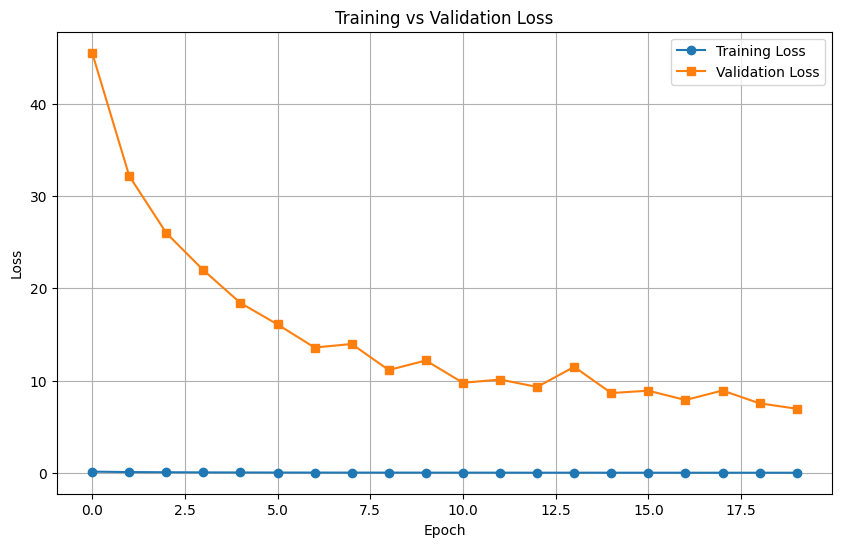

[Epoch 1, Batch 500] loss: 3.5634
[Epoch 2, Batch 500] loss: 0.8234
[Epoch 3, Batch 500] loss: 0.5724
[Epoch 4, Batch 500] loss: 0.4656
[Epoch 5, Batch 500] loss: 0.4016
[Epoch 6, Batch 500] loss: 0.3705
[Epoch 7, Batch 500] loss: 0.3276
[Epoch 8, Batch 500] loss: 0.3065
[Epoch 9, Batch 500] loss: 0.2946
[Epoch 10, Batch 500] loss: 0.2695
[Epoch 11, Batch 500] loss: 0.2573
[Epoch 12, Batch 500] loss: 0.2401
[Epoch 13, Batch 500] loss: 0.2427
[Epoch 14, Batch 500] loss: 0.2252
[Epoch 15, Batch 500] loss: 0.2228
[Epoch 16, Batch 500] loss: 0.2052
[Epoch 17, Batch 500] loss: 0.1961
[Epoch 18, Batch 500] loss: 0.1926
[Epoch 19, Batch 500] loss: 0.1867
[Epoch 20, Batch 500] loss: 0.1712


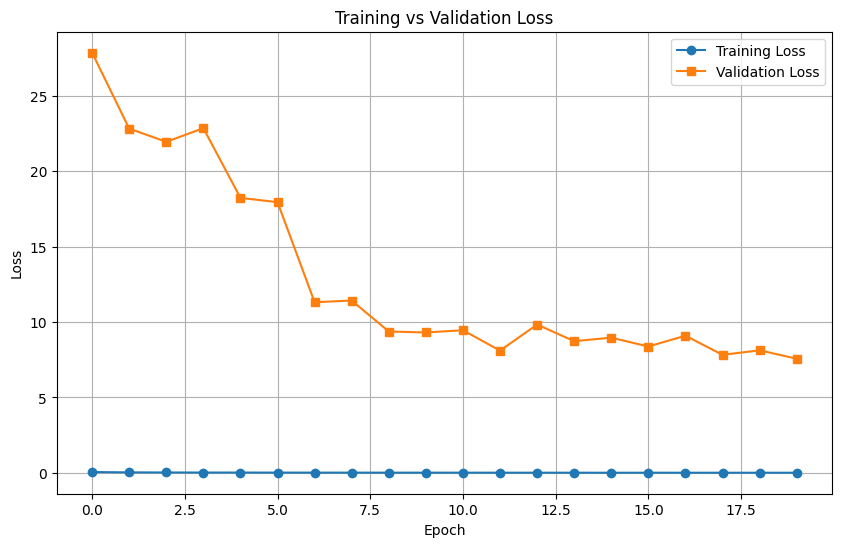

Accuracy: 97.76428571428572
97.76428571428572
Accuracy: 97.93571428571428
97.93571428571428


In [56]:
model_no_normalization = trainCNN(CNN_dropout(rate=0.3))
model_normalization = trainCNN(CNN_batchNormalization(rate=0.1))
print(evaluateTestCNN(model_no_normalization))
print(evaluateTestCNN(model_normalization))